### Food vision project

Build a classification model on the [food101 dataset](https://www.tensorflow.org/datasets/catalog/food101) using tensorflow

This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

In [30]:
# import libraries
import tensorflow_datasets as tfds
from utils import checkpoint_callback_weights_only, create_tensorboard_callback, plot_training_curves
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers.experimental import preprocessing

#### Load the data

In [ ]:
(train_data, valid_data), ds_info = tfds.load(
    name = 'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True, # data gets returned in tuple format (data, label)
    with_info=True # Get also the meta data
)

### Exploring our data
    - class names
    - The shape of the input data
    - The datatype of our input data
    - What the labels look like
    - Do the label match with the class names

In [3]:
# Features of food101 from tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [4]:
# get the class names
class_names = ds_info.features['label'].names
print('Number of classes:', len(class_names))
print(class_names[:10])

Number of classes: 101
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [5]:
# take one sample of our train data
train_data_one_sample = train_data.take(1) # samples are in the format (image_tensor, label)
train_data_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
# output info about our training data
for image, label in train_data_one_sample:
    print(f"""
        Image shape: {image.shape},
        Image datatype: {image.dtype},
        Target class from Food101 (tensor form): {label},
        Class name (str form): {class_names[label.numpy()]}
    """)


        Image shape: (512, 289, 3),
        Image datatype: <dtype: 'uint8'>,
        Target class from Food101 (tensor form): 45,
        Class name (str form): frozen_yogurt
    


#### Plot an image from our dataset

(-0.5, 288.5, 511.5, -0.5)

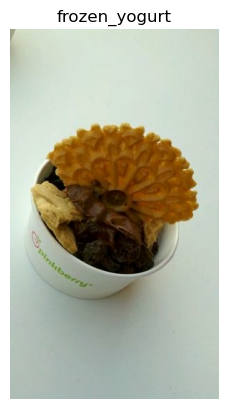

In [7]:
# plot an image tensor
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

#### create preprocessing functions for our data
    - Reshape our images to all the same size
    - Convert the dtype of our image temsors from unit8 to float32
    - 4

In [8]:
def preprocess_img(image, label, img_shape=224):
    """
    Convert image datatype from 'unit8' to 'float32' and reshapes
    image to [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape])
    # image = 1/255. # rescale the image to be between 0-1  (But not needed as I'm using efficientNetB0)
    return tf.cast(image, tf.float32), label

In [9]:
# preprocess a single sample image and check the result
preprocessed_img = preprocess_img(image, label)
preprocessed_img[0].shape, preprocessed_img[0].dtype

(TensorShape([224, 224, 3]), tf.float32)

#### Batch and prepare our dataset

In [10]:
# MAp preprocessing function to training (and parallelize)
train_data = train_data.map(
    map_func=preprocess_img, 
    num_parallel_calls=tf.data.AUTOTUNE) # use all the compute power you can find while performing the map opreration

# Shuffle train_data and and trun it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(
    buffer_size=1000 # shuffle a 1000 sample at a time
).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # once it's dealing with one batch get another batch ready tp process

In [11]:
# MAp preprocessing function to training (and parallelize)
valid_data = valid_data.map(
    map_func=preprocess_img, 
    num_parallel_calls=tf.data.AUTOTUNE) # use all the compute power you can find while performing the map opreration

# Shuffle train_data and and trun it into batches and prefetch it (load it faster)
valid_data = valid_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # once it's dealing with one batch get another batch ready tp process

In [12]:
train_data, valid_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

#### Model creation

#### Create a model checkpoint

In [18]:
checkpoint_path = "model_checkpoints/cp.ckpt"

#### Set mix_precision training

In [27]:
# use a combination of float16 and float32 to make the traning process more faster and speed up model performance
mixed_precision.set_global_policy('mixed_float16')

In [39]:
mixed_precision.global_policy()

<Policy "mixed_float16">

#### Build the feature extraction model

In [31]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255)
], name='data_augmentation')

In [34]:
# create the base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create functional model
inputs = tf.keras.layers.Input(shape=input_shape, name='input layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x) # for numerical stability

model = tf.keras.Model(inputs, outputs)

In [41]:
# compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
    optimizer='Adam'
)

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0     

In [37]:
# checking layer dtype policies (see if mix_precision is really working)
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input layer True float32 <Policy "float32">
data_augmentation True float32 <Policy "mixed_float16">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [44]:
# fit the model
history = model.fit(
    train_data,
    epochs=5,
    validation_data=valid_data,
    callbacks=[
        create_tensorboard_callback('tensorboard', 'feature_extraction'),
        checkpoint_callback_weights_only(checkpoint_path)
    ]
)

Saving Tensorboard log files to: tensorboard/feature_extraction/20230808-185154
Epoch 1/5
2368/2368 [==============================] - 395s 166ms/step - loss: 1.7867 - accuracy: 0.5536 - val_loss: 1.2703 - val_accuracy: 0.6567
Epoch 2/5
2368/2368 [==============================] - 265s 110ms/step - loss: 1.5510 - accuracy: 0.6048 - val_loss: 1.1841 - val_accuracy: 0.6782
Epoch 3/5
2368/2368 [==============================] - 256s 107ms/step - loss: 1.4521 - accuracy: 0.6258 - val_loss: 1.1481 - val_accuracy: 0.6877
Epoch 4/5
2368/2368 [==============================] - 236s 98ms/step - loss: 1.3849 - accuracy: 0.6394 - val_loss: 1.1258 - val_accuracy: 0.6965
Epoch 5/5
2368/2368 [==============================] - 265s 110ms/step - loss: 1.3401 - accuracy: 0.6490 - val_loss: 1.1148 - val_accuracy: 0.6973


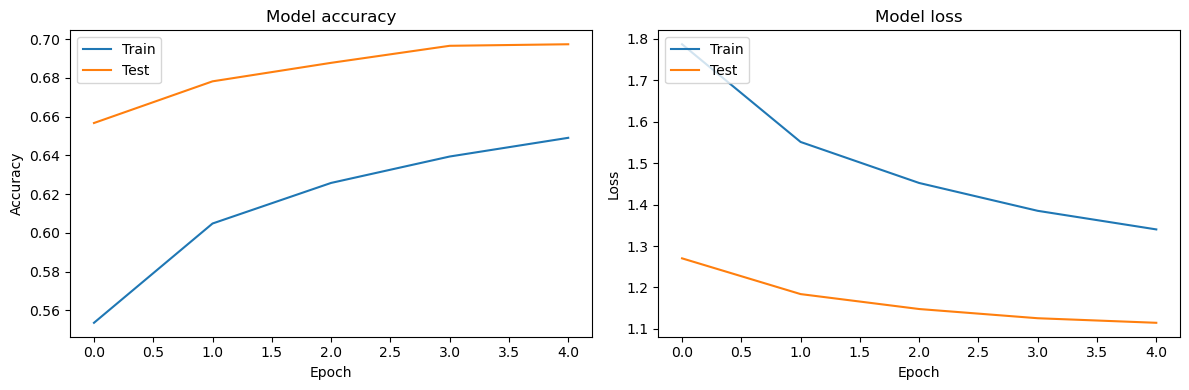

In [46]:
plot_training_curves(history)

In [47]:
# to begin fine-tune, let's start by setting the last 10 layers of our base_model.trainable to true
base_model.trainable = True

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False
    
# recompile our model every time we make a change
model.compile(
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001) # when fine-tining u typically want to lower your learning rateby 10x (check ULMFIT paper)
)

In [49]:
history_fine_tuned = model.fit(
    train_data,
    epochs=10,
    validation_data=valid_data,
    initial_epoch=history.epoch[-1] 
)

Epoch 5/10
2368/2368 [==============================] - 283s 112ms/step - loss: 1.2084 - accuracy: 0.6800 - val_loss: 1.0296 - val_accuracy: 0.7186
Epoch 6/10
2368/2368 [==============================] - 285s 119ms/step - loss: 1.0978 - accuracy: 0.7067 - val_loss: 1.0047 - val_accuracy: 0.7260
Epoch 7/10
2368/2368 [==============================] - 263s 110ms/step - loss: 1.0289 - accuracy: 0.7221 - val_loss: 0.9856 - val_accuracy: 0.7314
Epoch 8/10
2368/2368 [==============================] - 262s 109ms/step - loss: 0.9723 - accuracy: 0.7361 - val_loss: 0.9848 - val_accuracy: 0.7316
Epoch 9/10
2368/2368 [==============================] - 264s 110ms/step - loss: 0.9235 - accuracy: 0.7484 - val_loss: 0.9725 - val_accuracy: 0.7350
Epoch 10/10
2368/2368 [==============================] - 232s 97ms/step - loss: 0.8805 - accuracy: 0.7586 - val_loss: 0.9773 - val_accuracy: 0.7330


In [50]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/model_checkpoints/ (stored 0%)
  adding: kaggle/working/model_checkpoints/checkpoint (deflated 38%)
  adding: kaggle/working/model_checkpoints/cp.ckpt.index (deflated 77%)
  adding: kaggle/working/model_checkpoints/cp.ckpt.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/tensorboard/ (stored 0%)
  adding: kaggle/working/tensorboard/feature_extraction/ (stored 0%)
  adding: kaggle/working/tensorboard/feature_extraction/20230808-185154/ (stored 0%)
  adding: kaggle/working/tensorboard/feature_extraction/20230808-185154/train/ (stored 0%)
  adding: kaggle/working/tensorboard/feature_extraction/20230808-185154/train/events.out.tfevents.1691520714.f37dc31a6237.28.2.v2 (deflated 92%)
  adding: kaggle/working/tensorboard/feature_extraction/20230808-185154/validation/ (stored 0%)
  adding: kaggle/working/tensorboard/feature_extraction/20230808-185154/validation/even